# 2 - Models as Web Endpoints

#### A model as an endpoint is a system that provides a prediction in response to a passed in set of parameters.

### In this notebook we will cover:
- Calling web services using Python.
- Setting up endpoints.
- Saving models so that they can be used in production environement.
- Hosting scikit-learn and Keras predictive models.
- Scaling up a service with Gunicorn and Heroku.
- Building an interactive web application with Ploty Dash.

## 2.1 - Web Services 

To get started with making web requests in Python, we'll use the Cats Facts Heroku app. 
Heroku is a cloud platform that works well for hosting Python applications.
The Cats Facts service provides a siple API that provides a Json response containing interesting tidbits about felines.

In [12]:
import requests

# /facts/random endpoint retrieve a random fact. 
result = requests.get("http://cat-fact.herokuapp.com/facts/random")
print(result)

# return payload as a Python dictionary
print(result.json())

# value of the 'text'Key
print(result.json()['text'])

<Response [200]>
{'used': False, 'source': 'api', 'type': 'cat', 'deleted': False, '_id': '591f98883b90f7150a19c283', '__v': 0, 'text': "The more cats are spoken to, the more they will speak back. You will learn a lot from your cat's wide vocabulary of chirps and meows.", 'updatedAt': '2020-01-02T02:02:48.612Z', 'createdAt': '2018-01-04T01:10:54.673Z', 'status': {'verified': True, 'sentCount': 1}, 'user': '5a9ac18c7478810ea6c06381'}
The more cats are spoken to, the more they will speak back. You will learn a lot from your cat's wide vocabulary of chirps and meows.


### 2.1.1 Echo Service 

Let's setup a simple echo application that returns the passed in message parameter as part of the response payload.
We will use Flask to build a web service hoseted on the EC2 instance.
this service can be called on the open web, using the public IP of the EC2 instance.

Flask est un framework open-source de développement web en Python.

In [3]:
import flask
# loading Flask library and creating a Flask object
app = flask.Flask(__name__)

# define a predict function as an endpoint  with a Flask annotation that specifies that the function should be hosted 
# at '/' and accesible by HTTP Get and Post.
@app.route("/", methods=["GET","POST"])
def predict():
    # define sucess key as False
    data = {"success": False}
    
    # check for passed in parameters (did the caller passed in arguments?)
    params = flask.request.json
    if params is None:
        params = flask.request.args
    
    # if parameters are found, echo the msg parameter 
    if "msg" in params.keys(): 
        data["response"] = params.get("msg")
        data["success"] = True
        
    # return a response in json format 
    return flask.jsonify(data)
    
# start the flask app using 0.0.0.0 host which allow remote connections
# Instead of running this code in this notebook, I saved it into echo.py and I run it from the terminal (Python 3 echo.py) 
#if __name__ == '__main__':
#    app.run(host='0.0.0.0')

type in http://Public_IP:5000 in a web brower on my local PC to call the application

### 2.1.2 Call the Service 

In [14]:
# 3 different ways to pass parameters:
# I used the IP 0.0.0.0 Because the service is running on the same machine (EC2), where my notebook is located
# However if you wanna call the service from a notebook located on your PC you should replace the IP by the public IP of the
# EC2 machine.

result = requests.get("http://0.0.0.0:5000/?msg=Hello from URL!")
print(result.json())

# using params with GET
result = requests.get("http://0.0.0.0:5000/",  params = { 'msg': 'Hello from params' })
print(result.json())

# using json with POST
result = requests.post("http://0.0.0.0:5000/",  json = { 'msg': 'Hello from data' })
print(result.json())

{'response': 'Hello from URL!', 'success': True}
{'response': 'Hello from params', 'success': True}
{'response': 'Hello from data', 'success': True}


In addition to passing values to a service, it can be usseful to pass larger payloads, such as images wehn hosting deep learning models. The images could be encoded as strings, which will work  with our existing echo service.

Below shows how to read in an image and perform base64 encoding on the image before adding it to the request object.
When the service responds we can use the PIL library to render the image as plot.


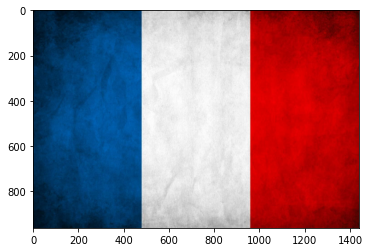

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64

# Let's try this with an image of France's flag <3 (vive la France).
image = open("France.jpg", "rb").read()
encoded = base64.b64encode(image)
result = requests.get("http://0.0.0.0:5000/", json = {'msg': encoded})

encoded = result.json()['response']
imgData = base64.b64decode(encoded)
plt.imshow( np.array(Image.open(io.BytesIO(imgData)) ))

## 2.2 Model Presistence

To host a model as a web service, we need to provide a model object for the predict function. 
We can train the model within the web service application, or we can use a pre-trained model.
Model presistence is a term used for saving and loading models within a predictive model pipeline.

In this section, we'll save and load both scikit-learn and Keras models, with both direct serialization and the MLFlow library.

### 2.2.1 Scikit_Learn

In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv")
x = df.drop(['label'], axis=1)
y = df['label']

model = LogisticRegression()
model.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We save the model using pickle! it provides a serialization of Python objects. dump fucntion to savea and load function to load it

In [19]:
import pickle
pickle.dump(model, open("logit.pkl", 'wb'))

model = pickle.load(open("logit.pkl", 'rb'))
model.predict_proba(x)

array([[0.93124982, 0.06875018],
       [0.86491573, 0.13508427],
       [0.85766917, 0.14233083],
       ...,
       [0.89969047, 0.10030953],
       [0.85766917, 0.14233083],
       [0.89969047, 0.10030953]])

Keep in mind that Pickle can run into serialization problems if your execution environement is different from your production environement. (example training on local machine using Python 3.6 but need to host the model on an EC2 running Python 3.7).
Solution? Use MLflow instead.

In [21]:
import mlflow
import mlflow.sklearn
import shutil

model_path = "models/logit_games_v1"

# uncomment this if you run this code multiple times (it allows MLflow to overide prvious model 
# at the same path instead of generating an error).
#shutil.rmtree(model_path)

mlflow.sklearn.save_model(model, model_path)

loaded = mlflow.sklearn.load_model(model_path)
loaded.predict_proba(x)

array([[0.93124982, 0.06875018],
       [0.86491573, 0.13508427],
       [0.85766917, 0.14233083],
       ...,
       [0.89969047, 0.10030953],
       [0.85766917, 0.14233083],
       [0.89969047, 0.10030953]])

### 2.2.2 Keras

Keras provides built-in functionalities for saving and loading deep learning models.

In [23]:
import tensorflow as tf
import keras
from keras import models, layers
import warnings
warnings.filterwarnings('ignore')


# define the network structure 
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# define ROC AUC as a metric 
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(
                  tf.local_variables_initializer())
    return auc
    
# compile and fit the model    
model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy', metrics=[auc])
history = model.fit(x, y, epochs=100, batch_size=100, 
                 validation_split = .2, verbose=0)

In [24]:
from keras.models import load_model

# saving model using the h5 format
model.save("games.h5")

# the custom function need to be passed to the load function.
model = load_model('games.h5', custom_objects={'auc': auc})
model.evaluate(x, y, verbose = 0)

[0.3045879865201429, 0.8167559409396562]

## 2.3 Model Endpoint